# Машинное обучение, ФКН ВШЭ

# Практическое задание 11. Несбалансированные задачи

## Общая информация
Дата выдачи: 24.04.2025

Мягкий дедлайн: 13.05.2025 23:59 MSK

Жесткий дедлайн: 18.05.2025 23:59 MSK

## Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

## Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-xx-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

## О задании

В этом задании мы разберем основные техники работы в задачах, где один из классов занимает существенно меньшую долю выборки, чем остальные. Для простоты мы обойдемся бинарной задачей, тем не менее, во многом данные методы можно перенести и на задачи с б**о**льшим числом классов. Кроме того, вы получите очередной бесценный опыт исследования случайной библиотеки случайных индусов с нуля.

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from jupyterthemes import jtplot

jtplot.style(theme='onedork')

**Задание -1 (1 балл)**. EDA

В качестве данных для нашей работы возьмем выложенный на kaggle датасет транзакций, в котором нужно выискивать мошеннические проводки: [клик](https://www.kaggle.com/mlg-ulb/creditcardfraud). Данная задача по определению подходит под несбалансированную, что можно сказать даже без наличия каких-либо данных (понятно, что среди всех транзакций клиентов очень малая часть будет мошеннической).

Загрузим данные, проведем некоторые классические манипуляции.

In [2]:
"""%%bash
kaggle datasets download -d mlg-ulb/creditcardfraud
unzip creditcardfraud.zip""";

In [3]:
df = pd.read_csv('creditcard.csv')

In [4]:
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,-1.593105,2.711941,-0.689256,4.626942,-0.924459,1.107641,1.991691,0.510632,-0.682920,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,-0.150189,0.915802,1.214756,-0.675143,1.164931,-0.711757,-0.025693,-1.221179,-1.545556,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,0.411614,0.063119,-0.183699,-0.510602,1.329284,0.140716,0.313502,0.395652,-0.577252,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,-1.933849,-0.962886,-1.042082,0.449624,1.962563,-0.608577,0.509928,1.113981,2.897849,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


Наши данные были анонимизированы. Мы имеем 30 признаков, из которых 28 - это результаты PCA-преобразования на исходном датасете. Еще 2 признака представляют собой время в секундах, прошедшее с момента первой транзакции в датасете, и размер транзакции. Скажите, какова доля положительных объектов в выборке?

In [5]:
positive_count = df['Class'].sum()
total_count = len(df)  
positive_proportion = positive_count / total_count

print(f"доля положительных объектов в выборке: {positive_proportion}")

доля положительных объектов в выборке: 0.001727485630620034


Постройте следующие графики:

1. Распределение числа транзакций по каждому часу (line-plot).
2. Распределение доли мошеннических транзакций по каждому часу (line-plot)
3. То же самое для дней (здесь можно использовать bar-plot, так как дней должно быть немного).

Какие выводы можно сделать из графиков? На ваш взгляд, как можно связать полученные нами часы с реальными часами в сутках?

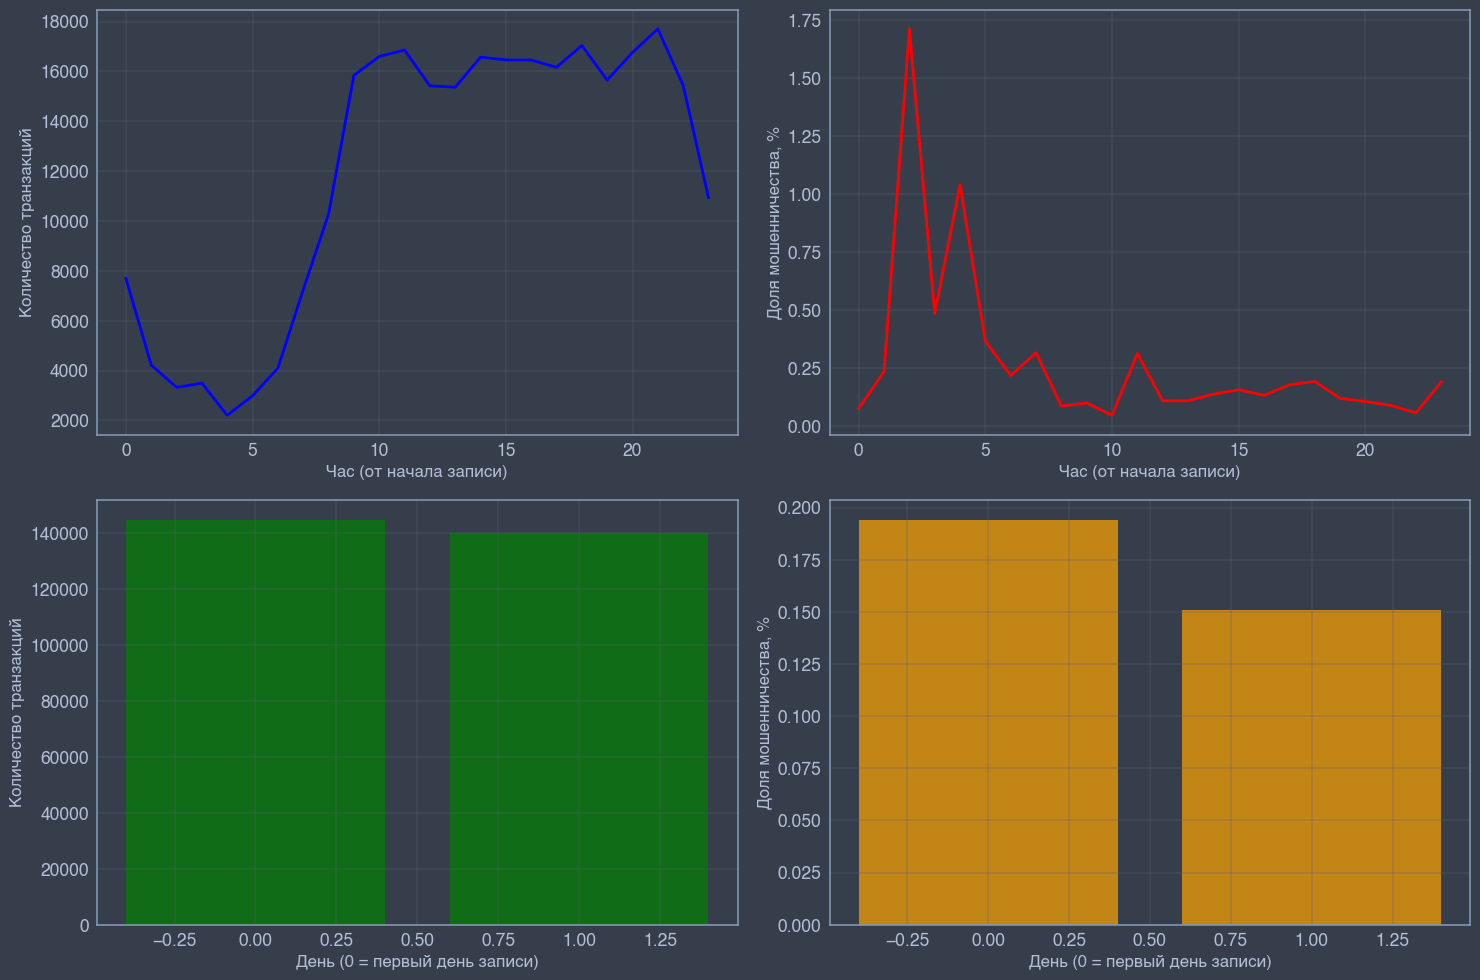

In [6]:
df['hour'] = (df['Time'] // 3600) % 24
df['day'] = df['Time'] // (24 * 3600)

hour_counts = df.groupby('hour').size()
hour_fraud_counts = df.groupby('hour')['Class'].sum()
hour_fraud_rate = hour_fraud_counts / hour_counts

day_counts = df.groupby('day').size()
day_fraud_counts = df.groupby('day')['Class'].sum()
day_fraud_rate = day_fraud_counts / day_counts

hour_fraud_rate = hour_fraud_rate.replace([np.inf, -np.inf], 0).fillna(0)
day_fraud_rate = day_fraud_rate.replace([np.inf, -np.inf], 0).fillna(0)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0, 0].plot(hour_counts.index, hour_counts.values, color='blue', linewidth=2)
axes[0, 0].set_xlabel('Час (от начала записи)', fontsize=12)
axes[0, 0].set_ylabel('Количество транзакций', fontsize=12)
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(hour_fraud_rate.index, hour_fraud_rate.values * 100, 
                color='red', linewidth=2)
axes[0, 1].set_xlabel('Час (от начала записи)', fontsize=12)
axes[0, 1].set_ylabel('Доля мошенничества, %', fontsize=12)
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].bar(day_counts.index, day_counts.values, color='green', alpha=0.7)
axes[1, 0].set_xlabel('День (0 = первый день записи)', fontsize=12)
axes[1, 0].set_ylabel('Количество транзакций', fontsize=12)
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].bar(day_fraud_rate.index, day_fraud_rate.values * 100, 
               color='orange', alpha=0.7)
axes[1, 1].set_xlabel('День (0 = первый день записи)', fontsize=12)
axes[1, 1].set_ylabel('Доля мошенничества, %', fontsize=12)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Очев что по часам распределение не равномерное, пик активности мошенников начинается с 5 часов по количественному соотношению, а по процентному соотношению явно лажа, около 20-25% в большую часть суток мошенничества
В нашем датасете не понятно с каких часов идет отсчет, в нашем случае 0 час это не по GMT+C, где C в москве +3, а просто первая запись, поэтому мы не можем сделать вывод утром днем или вечером орудуют мошенники

С анонимизированными признаками вряд ли можно придумать что-то интересное. Попробуйте (например, с помощью корреляции?) выбрать несколько наиболее важных признаков и поглядеть на различия в их распределении для разных классов.

In [7]:
correlations = df.corr()['Class'].sort_values(ascending=False)

correlations = correlations.drop('Class')

print(correlations.head(15))
print("\nОтрицательные корреляции:\n")
print(correlations.tail(15))

V11       0.154876
V4        0.133447
V2        0.091289
V21       0.040413
V19       0.034783
V20       0.020090
V8        0.019875
V27       0.017580
V28       0.009536
Amount    0.005632
V26       0.004455
V25       0.003308
V22       0.000805
V23      -0.002685
V15      -0.004223
Name: Class, dtype: float64

Отрицательные корреляции:

V24    -0.007221
Time   -0.012323
hour   -0.017109
V6     -0.043643
V5     -0.094974
V9     -0.097733
V1     -0.101347
V18    -0.111485
V7     -0.187257
V3     -0.192961
V16    -0.196539
V10    -0.216883
V12    -0.260593
V14    -0.302544
V17    -0.326481
Name: Class, dtype: float64


Теперь давайте разделим данные. Отделите хронологически последние 20% транзакций и поделите их пополам (также хронологически, т.е. без перемешивания) на валидационные и тестовые. Это разбиение не совсем корректно (как можно было заметить, мошеннические транзакции имеют разное распределение во времени - по-хорошему, нам стоило бы выделить целые сутки записей как под валидацию, так и под тест), тем не менее, мы не сможем получить больше данных для адекватного контроля, поэтому обойдемся этим. 

In [8]:
df = df.sort_values('Time').reset_index(drop=True)

split_idx = int(len(df) * 0.8)
train = df.iloc[:split_idx].copy()
holdout = df.iloc[split_idx:].copy()

val_test_split_idx = int(len(holdout) * 0.5)
validation = holdout.iloc[:val_test_split_idx].copy() 
test = holdout.iloc[val_test_split_idx:].copy()

X_train = train.drop('Class', axis=1)
y_train = train['Class']
X_val = validation.drop('Class', axis=1)
y_val = validation['Class']
X_test = test.drop('Class', axis=1)
y_test = test['Class']

# Часть 1. Несбалансированная классификация.

**Задание 0. (1 балл)**: перед началом работы давайте поговорим о том, как мы будем оценивать качество. Классические метрики для качества классификации чаще всего "ломаются" на задачах с сильным перекосом. Чему будет равно значение accuracy для наивного предсказания (= мажорный класс для каждого объекта)? (можете не отвечать, просто подумайте)

Из курса МО-1 вам уже известно, что мы можем использовать в таких задачах `AUC-PR` и получать адекватные показатели. Можно сказать, что `AUC-PR` представляет собой матожидание `precision` по распределению, заданному выигрышем в `recall` при смене порога. 

Тем не менее, существуют и другие, не менее интересные метрики. Одной из таких метрик является коэффициент Каппа Коэна, представляющий собой нормализованную `accuracy`:

$$\kappa = \frac{p_o - p_e}{1 - p_e}$$

Данная метрика служит в качестве меры согласованности между двумя независимыми предсказателями, но ничего не знает про "верные" и "предсказанные" метки (в отличие от многих других метрик машинного обучения). Здесь $p_o$ - доля согласованных предсказаний, а $p_e$ - доля согласованных предсказаний, которая могла бы получиться при случайных ответах предсказателей. В нашем случае это работает так:

• В качестве $p_o$ берем accuracy

• В качестве $p_e$ примем следующую величину - вероятность случайного соглашения позитивных ответов (произведение долей позитивных ответов в обоих предсказаниях) плюс вероятность случайного соглашения негативных ответов (произведение долей негативных ответов в обоих предсказаниях)

Метрика принимает значения от -1 до 1, где 1 - полная согласованность, 0 - согласованность на уровне рандома, -1 - совсем плохо. Как уже говорилось, метрика не различает "верные" и "предсказанные" метки, поэтому является симметричной (можете использовать это для отладки):

In [9]:
# p_0 - accuracy
# p_e - вероятность случайного соглашения позитивных ответов (произведение долей позитивных ответов в обоих предсказаниях)
#       плюс вероятность случайного соглашения негативных ответов
#       (произведение долей негативных ответов в обоих предсказаниях)
from sklearn.metrics import confusion_matrix

def kappa_coen(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    n = tn + fp + fn + tp
    
    p_o = (tp + tn) / n
    
    p_real_pos = (tp + fn) / n
    p_pred_pos = (tp + fp) / n
    p_real_neg = (tn + fp) / n 
    p_pred_neg = (tn + fn) / n
    
    p_e = (p_real_pos * p_pred_pos) + (p_real_neg * p_pred_neg)
    
    kappa_coen = (p_o - p_e) / (1 - p_e)
    return kappa_coen

Еще одной метрикой в такой задаче служит коэффициент корреляции Мэтьюза, выражающийся в терминах матрицы ошибок следующим образом:

$$\text{MCC} = \frac{TP\times TN - FP \times FN}{\sqrt{(TP+FP)(TP+FN)(TN+FP)(TN+FN)}}$$ 

Метрика принимает значения от -1 до 1, интерпретируемые аналогичным образом. 

In [10]:
def calculate_mcc(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    numerator = (tp * tn) - (fp * fn)
    denominator = np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
    
    if denominator == 0:
        return 0.0
    
    mcc = numerator / denominator
    return mcc

Обратите внимание, что эти метрики вычисляются на бинаризованных предсказаниях, поэтому может иметь смысл дополнительная настройка порога бинаризации.

Давайте проверим, что наши метрики действительно подходят под задачу. Вычислите их значения для наивного предсказания (aka мажорный класс для всех объектов):

In [11]:
y_pred_naive = np.zeros(len(y_test))

print(f"kappa_coen coef: {kappa_coen(y_test, y_pred_naive)}")
print(f"MCC coef corr: {calculate_mcc(y_test, y_pred_naive)}")

kappa_coen coef: 0.0
MCC coef corr: 0.0


Давайте запустим бейзлайн-решение для нашей задачи. С чего же начнем? Возьмите `catboost` и обучите его классификатор на наших данных (используйте все признаки). Вычислите значения всех метрик на тестовой части, для контроля переобучения используйте валидационную (здесь и далее везде, где фигурирует `catboost`). 

In [12]:
!pip install catboost

In [13]:
from catboost import CatBoostClassifier

In [14]:
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score)

model = CatBoostClassifier(verbose = False)
model.fit(X_train, y_train, eval_set=(X_val, y_val))

y_pred_proba = model.predict_proba(X_test)[:, 1]
y_pred = (y_pred_proba >= 0.5).astype(int)

metrics = {
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred, zero_division=0),
    'Recall': recall_score(y_test, y_pred, zero_division=0),
    'F1': f1_score(y_test, y_pred, zero_division=0),
    'MCC': calculate_mcc(y_test, y_pred),
    'Kappa': kappa_coen(y_test, y_pred)
}

metrics

{'Accuracy': 0.9996137776061234,
 'Precision': 0.8235294117647058,
 'Recall': 0.6363636363636364,
 'F1': 0.717948717948718,
 'MCC': np.float64(0.7237392722838328),
 'Kappa': np.float64(0.717758652842163)}

Если вы все сделали правильно, у вас должны были получиться значения в районе 0.7.

**Задание 1. (1 балл)**. Многие реализации методов предлагают встроенные способы для борьбы с нашей проблемой. Самое часто встречающееся решение - просто добавить вес в функции потерь для минорного класса (таким образом, ошибка на объекте минорного класса будет весить больше, чем для мажорного). В `catboost` это также реализовано, причем для бинарной задачи это можно сделать целыми двумя способами (можете выбрать любой, на свой вкус, автор задания предпочитает отдельный скейлинг для минорного класса). Чаще всего в качестве веса берется отношение числа объектов мажорного класса к числу минорного. Попробуйте обучить модель с таким скалированием и сравните метрики на тестовой части с бейзлайном.

In [15]:
scale_pos_weight = len(y_train[y_train==0]) / len(y_train[y_train==1])

model_weighted = CatBoostClassifier(
    scale_pos_weight=scale_pos_weight,
    verbose=False
)

model_weighted.fit(X_train, y_train, eval_set=(X_val, y_val))
y_pred_proba_weighted = model_weighted.predict_proba(X_test)[:, 1]
y_pred_weighted = (y_pred_proba_weighted >= 0.5).astype(int)

metrics_weighted = {
    'Accuracy': accuracy_score(y_test, y_pred_weighted),
    'Precision': precision_score(y_test, y_pred_weighted, zero_division=0),
    'Recall': recall_score(y_test, y_pred_weighted, zero_division=0),
    'F1': f1_score(y_test, y_pred_weighted, zero_division=0),
    'MCC': calculate_mcc(y_test, y_pred_weighted),
    'Kappa': kappa_coen(y_test, y_pred_weighted)
}
metrics_weighted

{'Accuracy': 0.991854218601875,
 'Precision': 0.06611570247933884,
 'Recall': 0.7272727272727273,
 'F1': 0.12121212121212122,
 'MCC': np.float64(0.21772980534275463),
 'Kappa': np.float64(0.1199658619433282)}

Поскольку данный вес будет являться гиперпараметром метода, было бы опрометчиво остановиться на одном значении (тем более, с большой вероятностью у вас все сломалось). Запустите перебор для этого гиперпараметра на валидационной выборке (используйте `PR-AUC`), подберите оптимальный порог бинаризации для $\kappa$ или $\text{MCC}$. Для лучшего найденного веса и порога вычислите все метрики на тестовой части. 

При этом можете также проверить отдельное скалирование в большую сторону для мажорного класса (т.е. веса минорного сделать меньше 1) и экстремальные скалирования (т.е. веса минорного больше, чем в начале этого задания). Какой вес получился оптимальным?

In [16]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    average_precision_score, matthews_corrcoef, cohen_kappa_score
)


scale_values = [0.1, 0.5, 1, 10, 50, 100, 300, 500, 578, 700, 900, 1200, 1500, 2000]

best_pr_auc = 0
best_scale = 1
best_threshold = 0.5
best_model = None

for scale in scale_values:
    model = CatBoostClassifier(
        scale_pos_weight=scale,
        random_seed=42,
        verbose=False
    )
    model.fit(X_train, y_train)
    
    y_pred_proba_val = model.predict_proba(X_val)[:, 1]
    
    pr_auc = average_precision_score(y_val, y_pred_proba_val)
    
    thresholds = np.linspace(0.01, 0.99, 100)
    best_mcc_for_scale = -1
    best_thresh_for_scale = 0.5
    
    for thresh in thresholds:
        y_pred_temp = (y_pred_proba_val >= thresh).astype(int)
        mcc = calculate_mcc(y_val, y_pred_temp)
        if mcc > best_mcc_for_scale:
            best_mcc_for_scale = mcc
            best_thresh_for_scale = thresh
    
    
    if pr_auc > best_pr_auc:
        best_pr_auc = pr_auc
        best_scale = scale
        best_threshold = best_thresh_for_scale
        best_model = model

print(f"\nЛучший: scale={best_scale}, PR-AUC={best_pr_auc:.4f}, порог={best_threshold:.4f}")

y_pred_proba_test = best_model.predict_proba(X_test)[:, 1]
y_pred_test = (y_pred_proba_test >= best_threshold).astype(int)
metrics_best = {
    'Accuracy': accuracy_score(y_test, y_pred_test),
    'Precision': precision_score(y_test, y_pred_test, zero_division=0),
    'Recall': recall_score(y_test, y_pred_test, zero_division=0),
    'F1': f1_score(y_test, y_pred_test, zero_division=0),
    'MCC': calculate_mcc(y_test, y_pred_test),
    'Kappa': kappa_coen(y_test, y_pred_test),
    'PR-AUC': average_precision_score(y_test, y_pred_proba_test)
}


Лучший: scale=0.5, PR-AUC=0.8492, порог=0.0397


In [17]:
metrics_best

{'Accuracy': 0.9995786664794073,
 'Precision': 0.7272727272727273,
 'Recall': 0.7272727272727273,
 'F1': 0.7272727272727273,
 'MCC': np.float64(0.7270618976581941),
 'Kappa': np.float64(0.7270618976582063),
 'PR-AUC': 0.7158287481056989}

**Задание 2. (1 балл)**. На самом деле, то, что мы сейчас делали, очень схоже с другой распространенной техникой - оверсэмплингом. Фактически, мы можем продублировать все объекты минорного класса и получить тот же эффект, какой был бы при использовании веса, равного 2. Тем не менее, такой подход - это лишь малая часть того, что мы можем проделать с целью повысить число объектов минорного класса. 

Для продолжения работы установим библиотеку [imbalanced-learn](https://imbalanced-learn.org/stable/):

In [18]:
!pip3 install imbalanced-learn
# conda install -c conda-forge imbalanced-learn

Первый метод, которым мы воспользуемся, называется SMOTE (его вы уже разбирали на лекции). Кратко напомним суть: мы выбираем случайного кандидата среди $k$ ближайших соседей объекта минорного класса, затем берем точку на отрезке между двумя объектами (т.е. выпуклую комбинацию со случайными коэффициентами) и добавляем в выборку. 

In [19]:
from imblearn.over_sampling import SMOTE

Используйте SMOTE для ресэмплинга обучающей выборки, на новой выборке обучите модель (вес положительных объектов скалировать не нужно). Замерьте качество на тестовой выборке (**важно!** не преобразовывайте валидационную и тестовую выборку никак - мы не хотим отслеживать качество на объектах, которых в реальности не существует). Сравните полное выравнивание выборки с частичным (т.е. таким, что баланс классов улучшается, но не достигает равенства - скажем, 1:2 и 1:10).

In [20]:
catboost = CatBoostClassifier(
        scale_pos_weight=1,
        random_seed=42,
        verbose=False
    )
RANDOM_STATE = 42

In [21]:
def calc_metrics(y_true, y_pred, y_proba=None):
    metrics = {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred, zero_division=0),
        'Recall': recall_score(y_true, y_pred, zero_division=0),
        'F1': f1_score(y_true, y_pred, zero_division=0),
        'MCC': matthews_corrcoef(y_true, y_pred),
        'Kappa': cohen_kappa_score(y_true, y_pred)
    }
    if y_proba is not None:
        metrics['PR-AUC'] = average_precision_score(y_true, y_proba)
    return metrics


strategies = {
    'partial 1:2': 0.5,
    'partial 1:10': 0.1
}

results = {}

for name, ratio in strategies.items():
    
    smote = SMOTE(sampling_strategy=ratio, random_state=42)
    X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
    
    model = CatBoostClassifier(iterations=500,
                               random_state=RANDOM_STATE,
                               verbose=0)
    model.fit(X_train_res, y_train_res)
    
    y_val_proba = model.predict_proba(X_val)[:, 1]
    
    thresholds = np.linspace(0.01, 0.99, 100)
    best_mcc = -1
    best_thresh = 0.5
    for thresh in thresholds:
        y_val_pred = (y_val_proba >= thresh).astype(int)
        mcc = matthews_corrcoef(y_val, y_val_pred)
        if mcc > best_mcc:
            best_mcc = mcc
            best_thresh = thresh
    
    y_test_proba = model.predict_proba(X_test)[:, 1]
    y_test_pred = (y_test_proba >= best_thresh).astype(int)
    
    metrics = calc_metrics(y_test, y_test_pred, y_test_proba)
    results[name] = {
        'metrics': metrics,
        'best_threshold': best_thresh,
        'model': model
    }

In [22]:
results

{'partial 1:2': {'metrics': {'Accuracy': 0.9997542221129876,
   'Precision': 0.9411764705882353,
   'Recall': 0.7272727272727273,
   'F1': 0.8205128205128205,
   'MCC': 0.8272276657666917,
   'Kappa': 0.8203918699904775,
   'PR-AUC': 0.7363751154131829},
  'best_threshold': np.float64(0.8118181818181818),
  'model': <catboost.core.CatBoostClassifier at 0x1689e60a0>},
 'partial 1:10': {'metrics': {'Accuracy': 0.9997191109862715,
   'Precision': 0.9375,
   'Recall': 0.6818181818181818,
   'F1': 0.7894736842105263,
   'MCC': 0.7993772213060292,
   'Kappa': 0.7893366519535417,
   'PR-AUC': 0.724789661263604},
  'best_threshold': np.float64(0.9603030303030302),
  'model': <catboost.core.CatBoostClassifier at 0x1689e5ff0>}}

Существенный прирост в метриках

**Бонус (1.5 балла)**. Для vanilla SMOTE существуют некоторые модификации, часть из которых была реализована в библиотеке imblearn. Во время лекций/семинаров эти модификации не рассматривались, тем не менее, мы все равно их исследуем.

Найдите статьи о следующих методах и попробуйте вкратце сформулировать, в чем их основная идея (сделайте так, чтобы человек, знакомый с машинным обучением в целом, но не слышавший конкретно про это смог понять):

1. BorderlineSMOTE - Генерирует синтетические объекты только для тех представителей минорного класса, которые находятся на границе раздела классов

2. SVM-SMOTE - Сначала на несбалансированных данных обучается SVM, затем выделяются опорные векторы, принадлежащие минорному классу. Новые синтетические примеры генерируются вдоль линий, соединяющих эти опорные векторы с их ближайшими соседями, что фокусирует генерацию вблизи границы классов, где они наиболее полезны.



3. K-Means-SMOTE - Кластеризация всего обучающего множества методом K‑means ->

   
-> выбор кластеров, в которых доля минорного класса высока (безопасные регионы) ->

-> Применение SMOTE внутри выбранных кластеров, причём количество генерируемых примеров пропорционально дисбалансу в кластере.

Такой подход позволяет избежать генерации шума в областях, где минорный класс представлен слабо

4. ADASYN - Адаптивно генерирует больше синтетических примеров для тех объектов минорного класса, которые труднее классифицировать. Для каждого образца меньшинства вычисляется отношение числа его соседей из мажорного класса к общему числу соседей – чем выше это отношение, тем «сложнее» пример. Затем количество новых примеров, создаваемых вокруг данного объекта, пропорционально этой мере сложности.

Теперь попробуйте сравнить качество всех методов на наших данных.

In [23]:
from imblearn.over_sampling import BorderlineSMOTE, SVMSMOTE, KMeansSMOTE, ADASYN

def find_best_threshold(y_true, y_proba, thresholds=np.linspace(0.01, 0.99, 100)):
    best_mcc = -1
    best_thresh = 0.5
    for thresh in thresholds:
        y_pred = (y_proba >= thresh).astype(int)
        mcc = matthews_corrcoef(y_true, y_pred)
        if mcc > best_mcc:
            best_mcc = mcc
            best_thresh = thresh
    return best_thresh

RANDOM_STATE = 42
SAMPLING_STRATEGY = 1.0
methods = {
    'BorderlineSMOTE': BorderlineSMOTE(sampling_strategy=SAMPLING_STRATEGY, random_state=RANDOM_STATE, kind='borderline-1'),
    'SVM-SMOTE': SVMSMOTE(sampling_strategy=SAMPLING_STRATEGY, random_state=RANDOM_STATE),
    'KMeans-SMOTE': KMeansSMOTE(sampling_strategy=SAMPLING_STRATEGY, random_state=RANDOM_STATE, k_neighbors=5, cluster_balance_threshold=0.00, kmeans_estimator=20),
    'ADASYN': ADASYN(sampling_strategy=SAMPLING_STRATEGY, random_state=RANDOM_STATE, n_neighbors=5)
}

results = {}

for name, sampler in methods.items():
    X_train_res, y_train_res = sampler.fit_resample(X_train, y_train)

    model = CatBoostClassifier(iterations=500,
                               random_state=RANDOM_STATE,
                               verbose=0)
    model.fit(X_train_res, y_train_res)

    y_val_proba = model.predict_proba(X_val)[:, 1]
    best_thresh = find_best_threshold(y_val, y_val_proba)

    y_test_proba = model.predict_proba(X_test)[:, 1]
    y_test_pred = (y_test_proba >= best_thresh).astype(int)

    metrics = calc_metrics(y_test, y_test_pred, y_test_proba)

    results[name] = {
        'metrics': metrics,
        'best_threshold': best_thresh
    }

In [24]:
for method_name, data in results.items():
    mcc = data['metrics']['MCC']
    print(f"{method_name}: MCC = {mcc:}")

BorderlineSMOTE: MCC = 0.7110586906187203
SVM-SMOTE: MCC = 0.7270618976581941
KMeans-SMOTE: MCC = 0.6976351100712623
ADASYN: MCC = 0.8272276657666917


**Задание 3. (1 балл)**. До этого момента все наши решения концентрировались на работе с минорным классом. Теперь давайте попробуем зайти с другой стороны. Может быть, для восстановления закономерностей нам не нужно столько объектов мажорного класса, и они просто засоряют нам выборку лишней информацией?

Для решения этой проблемы существуют методы андерсэмплинга. Самое простое, что можно придумать - удалять точки мажорного класса, пока мы не получим приемлемый баланс. Протестируйте следующий метод и постройте графики достигаемых значений метрик от баланса классов и от отношения размеров исходной и пересэмпленной выборки:

In [25]:
from imblearn.under_sampling import RandomUnderSampler

In [26]:
RANDOM_STATE = 42
N_THRESHOLDS = 100
CATBOOST_ITERATIONS = 500

n_minor_orig = sum(y_train == 1)
n_major_orig = sum(y_train == 0)
orig_ratio = n_minor_orig / n_major_orig
orig_minor_frac = n_minor_orig / (n_minor_orig + n_major_orig)

strategies = np.linspace(0.01, 1.0, 20)
results = []

for strat in strategies:
    rus = RandomUnderSampler(sampling_strategy=strat, random_state=RANDOM_STATE)
    X_train_res, y_train_res = rus.fit_resample(X_train, y_train)

    n_minor_res = sum(y_train_res == 1)
    n_major_res = sum(y_train_res == 0)
    actual_ratio = n_minor_res / n_major_res
    minor_frac = n_minor_res / (n_minor_res + n_major_res)
    sample_retain_frac = len(y_train_res) / len(y_train)

    # Создаём и обучаем модель CatBoost
    model = CatBoostClassifier(iterations=CATBOOST_ITERATIONS,
                               random_state=RANDOM_STATE,
                               verbose=0,
                               allow_writing_files=False)
    model.fit(X_train_res, y_train_res)

    y_val_proba = model.predict_proba(X_val)[:, 1]
    best_thresh = find_best_threshold(y_val, y_val_proba,
                                      thresholds=np.linspace(0.01, 0.99, N_THRESHOLDS))

    y_test_proba = model.predict_proba(X_test)[:, 1]
    y_test_pred = (y_test_proba >= best_thresh).astype(int)

    metrics = calc_metrics(y_test, y_test_pred, y_test_proba)

    results.append({
        'target_strategy': strat,
        'actual_ratio': actual_ratio,
        'minor_frac': minor_frac,
        'sample_retain_frac': sample_retain_frac,
        'best_threshold': best_thresh,
        **metrics
    })

df = pd.DataFrame(results)

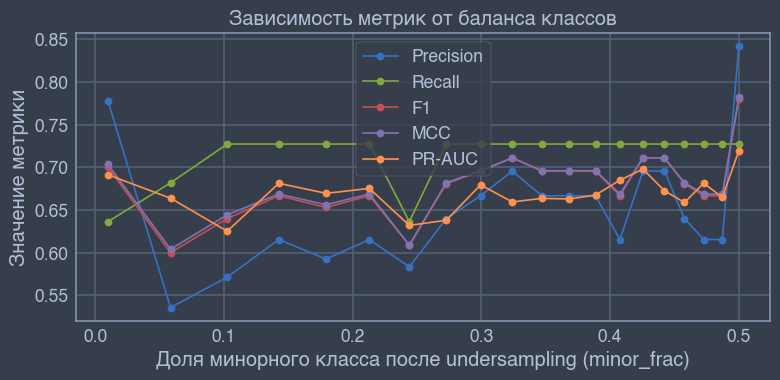

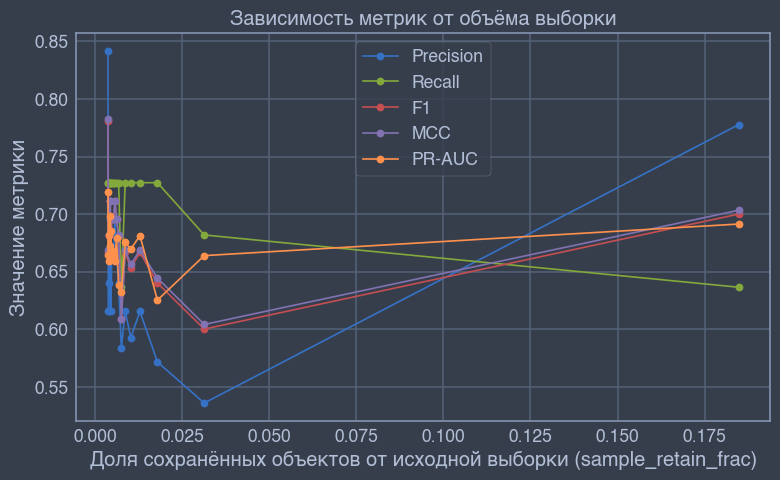

In [27]:
metrics = ['Precision', 'Recall', 'F1', 'MCC', 'PR-AUC']

df = df.sort_values('minor_frac')

plt.figure(figsize=(8, 4))
for metric in metrics:
    plt.plot(df['minor_frac'], df[metric], 'o-', label=metric)
plt.xlabel('Доля минорного класса после undersampling (minor_frac)')
plt.ylabel('Значение метрики')
plt.title('Зависимость метрик от баланса классов')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
for metric in metrics:
    plt.plot(df['sample_retain_frac'], df[metric], 'o-', label=metric)
plt.xlabel('Доля сохранённых объектов от исходной выборки (sample_retain_frac)')
plt.ylabel('Значение метрики')
plt.title('Зависимость метрик от объёма выборки')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Даже такой наивный подход может дать относительно неплохие результаты и улучшить наши метрики. Тем не менее, сейчас мы никак не используем информацию о распределении объектов в выборке. Оказывается, что даже относительно простые эвристические правила могут заметно поднять нам качество - например, мы можем при отбрасывании использовать близость отдельных объектов мажорного класса к минорному и отбрасывать самые близкие. Протестируйте алгоритм [Near-Miss](https://www.site.uottawa.ca/~nat/Workshop2003/jzhang.pdf) на наших данных и постройте графики, аналогичные предыдущему пункту (также добавьте график с зависимостью качества от числа соседей).

In [28]:
from imblearn.under_sampling import NearMiss

RANDOM_STATE = 42
N_THRESHOLDS = 100
CATBOOST_ITERATIONS = 500
N_NEIGHBORS_FIXED = 5

strategies = np.linspace(0.01, 1.0, 20)
results_strategy = []

for strat in strategies:
    nm = NearMiss(sampling_strategy=strat, version=1, n_neighbors=N_NEIGHBORS_FIXED)
    X_train_res, y_train_res = nm.fit_resample(X_train, y_train)

    n_minor_res = sum(y_train_res == 1)
    n_major_res = sum(y_train_res == 0)
    minor_frac = n_minor_res / (n_minor_res + n_major_res)
    sample_retain_frac = len(y_train_res) / len(y_train)

    model = CatBoostClassifier(iterations=CATBOOST_ITERATIONS,
                               random_state=RANDOM_STATE,
                               verbose=0)
    model.fit(X_train_res, y_train_res)

    y_val_proba = model.predict_proba(X_val)[:, 1]
    best_thresh = find_best_threshold(y_val, y_val_proba,
                                      thresholds=np.linspace(0.01, 0.99, N_THRESHOLDS))

    y_test_proba = model.predict_proba(X_test)[:, 1]
    y_test_pred = (y_test_proba >= best_thresh).astype(int)

    metrics = calc_metrics(y_test, y_test_pred, y_test_proba)

    results_strategy.append({
        'target_strategy': strat,
        'minor_frac': minor_frac,
        'sample_retain_frac': sample_retain_frac,
        'best_threshold': best_thresh,
        **metrics
    })

df_nearmiss = pd.DataFrame(results_strategy)

In [29]:
FIXED_STRATEGY = 0.7
neighbors_range = range(1, 21)
results_neighbors = []

for n_neigh in neighbors_range:
    nm = NearMiss(sampling_strategy=FIXED_STRATEGY, version=1, n_neighbors=n_neigh)
    X_train_res, y_train_res = nm.fit_resample(X_train, y_train)

    n_minor_res = sum(y_train_res == 1)
    n_major_res = sum(y_train_res == 0)
    minor_frac = n_minor_res / (n_minor_res + n_major_res)
    sample_retain_frac = len(y_train_res) / len(y_train)

    # Обучение модели
    model = CatBoostClassifier(iterations=CATBOOST_ITERATIONS,
                               random_state=RANDOM_STATE,
                               verbose=0)
    model.fit(X_train_res, y_train_res)

    y_val_proba = model.predict_proba(X_val)[:, 1]
    best_thresh = find_best_threshold(y_val, y_val_proba,
                                      thresholds=np.linspace(0.01, 0.99, N_THRESHOLDS))

    y_test_proba = model.predict_proba(X_test)[:, 1]
    y_test_pred = (y_test_proba >= best_thresh).astype(int)

    metrics = calc_metrics(y_test, y_test_pred, y_test_proba)

    results_neighbors.append({
        'n_neighbors': n_neigh,
        'minor_frac': minor_frac,
        'sample_retain_frac': sample_retain_frac,
        'best_threshold': best_thresh,
        **metrics
    })

df_neighbors = pd.DataFrame(results_neighbors)

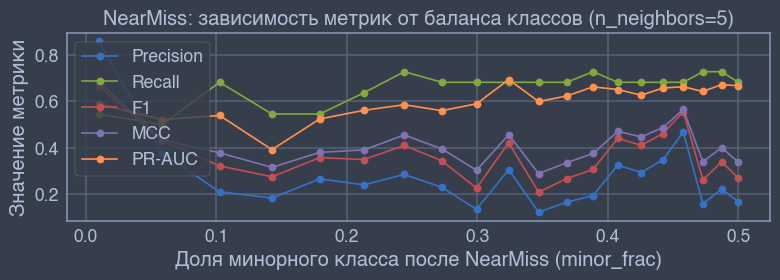

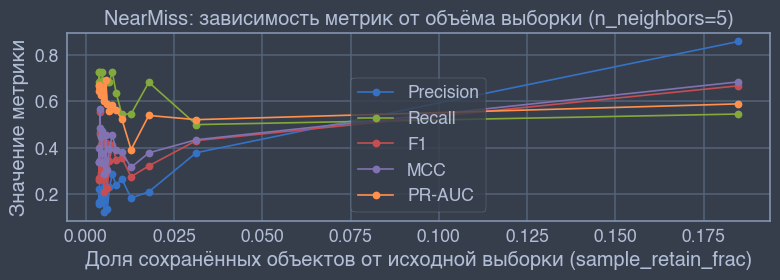

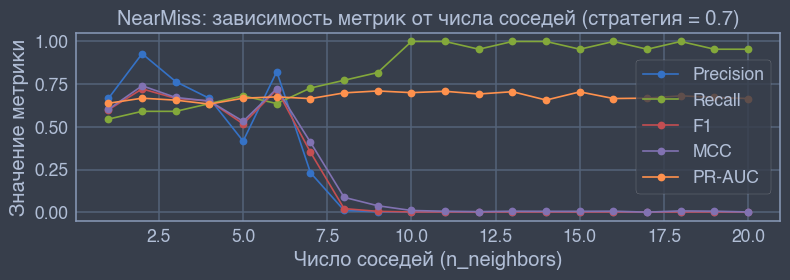

In [30]:
metrics_to_plot = ['Precision', 'Recall', 'F1', 'MCC', 'PR-AUC']

df_nearmiss_sorted = df_nearmiss.sort_values('minor_frac')
plt.figure(figsize=(8, 3))
for metric in metrics_to_plot:
    if metric in df_nearmiss_sorted.columns:
        plt.plot(df_nearmiss_sorted['minor_frac'], df_nearmiss_sorted[metric], 'o-', label=metric)
plt.xlabel('Доля минорного класса после NearMiss (minor_frac)')
plt.ylabel('Значение метрики')
plt.title('NearMiss: зависимость метрик от баланса классов (n_neighbors=5)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 3))
for metric in metrics_to_plot:
    if metric in df_nearmiss_sorted.columns:
        plt.plot(df_nearmiss_sorted['sample_retain_frac'], df_nearmiss_sorted[metric], 'o-', label=metric)
plt.xlabel('Доля сохранённых объектов от исходной выборки (sample_retain_frac)')
plt.ylabel('Значение метрики')
plt.title('NearMiss: зависимость метрик от объёма выборки (n_neighbors=5)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

df_neighbors_sorted = df_neighbors.sort_values('n_neighbors')
plt.figure(figsize=(8, 3))
for metric in metrics_to_plot:
    if metric in df_neighbors_sorted.columns:
        plt.plot(df_neighbors_sorted['n_neighbors'], df_neighbors_sorted[metric], 'o-', label=metric)
plt.xlabel('Число соседей (n_neighbors)')
plt.ylabel('Значение метрики')
plt.title(f'NearMiss: зависимость метрик от числа соседей (стратегия = {FIXED_STRATEGY})')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**Бонус (1 балл)**. imblearn также предлагает много различных методов для андерсэмплинга. Выберите что-нибудь еще из предлагаемого на свой вкус, опишите идею метода и протестируйте его.


In [31]:
from imblearn.under_sampling import EditedNearestNeighbours

NEIGHBORS_RANGE = range(3, 22, 4)

def evaluate_enn(n_neighbors):
    enn = EditedNearestNeighbours(n_neighbors=n_neighbors, kind_sel='mode',
                                  sampling_strategy='auto', n_jobs=-1)
    X_res, y_res = enn.fit_resample(X_train, y_train)

    n_minor = np.sum(y_res == 1)
    n_major = np.sum(y_res == 0)
    minor_frac = n_minor / (n_minor + n_major) if (n_minor + n_major) else 0
    sample_retain_frac = len(y_res) / len(y_train)

    model = CatBoostClassifier(iterations=200,
                               random_state=RANDOM_STATE,
                               verbose=0)
    model.fit(X_res, y_res)

    y_val_proba = model.predict_proba(X_val)[:, 1]
    best_thresh = find_best_threshold(y_val, y_val_proba,
                                      thresholds=np.linspace(0.01, 0.99, N_THRESHOLDS))

    y_test_proba = model.predict_proba(X_test)[:, 1]
    y_test_pred = (y_test_proba >= best_thresh).astype(int)

    metrics = calc_metrics(y_test, y_test_pred, y_test_proba)

    return {
        'n_neighbors': n_neighbors,
        'minor_frac': minor_frac,
        'sample_retain_frac': sample_retain_frac,
        'best_threshold': best_thresh,
        **metrics
    }

results_enn = [evaluate_enn(n) for n in NEIGHBORS_RANGE]
df_enn = pd.DataFrame(results_enn).sort_values('n_neighbors')

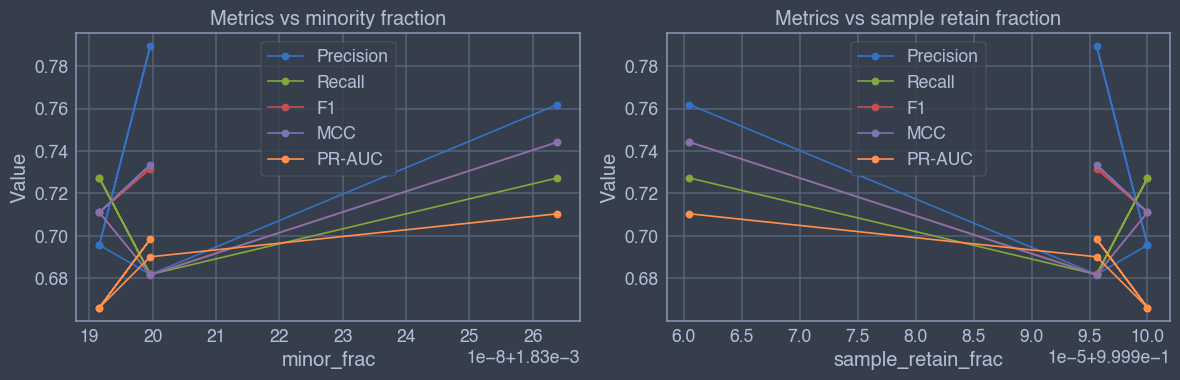

In [32]:
metrics = ['Precision', 'Recall', 'F1', 'MCC', 'PR-AUC']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

for metric in metrics:
    ax1.plot(df_enn['minor_frac'], df_enn[metric], 'o-', label=metric)
ax1.set_xlabel('minor_frac')
ax1.set_ylabel('Value')
ax1.set_title('Metrics vs minority fraction')
ax1.legend()
ax1.grid(True)

for metric in metrics:
    ax2.plot(df_enn['sample_retain_frac'], df_enn[metric], 'o-', label=metric)
ax2.set_xlabel('sample_retain_frac')
ax2.set_ylabel('Value')
ax2.set_title('Metrics vs sample retain fraction')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

# Часть 2. Поиск аномалий. 

Как вы могли заметить, методы балансировки выборок очень часто могут привести к не самым лучшим результатам из-за того, что они по сути искажают информацию о реальном распределении данных - в реальности обычно требуется долгий подбор в принципе работоспособных для задачи методов и их аккуратная настройка. 

Теперь давайте попробуем слегка сменить постановку задачи и переключиться на задачу "одноклассовой" классификации, то есть - поиска *аномалий* в выборке. В общем-то, это вполне согласуется с нашей областью работы - мы действительно можем назвать мошеннические транзакции аномальньми (как интуитивно, так и на основании наблюдаемой балансировки данных). 

Стоит отметить, что методы обнаружения аномалий чаще всего относятся к классу методов обучения без учителя. Это дает некоторый положительный эффект - нам не обязательно нужно тратить время на разметку данных (тем не менее, для контроля качества какую-то часть разметить все-таки придется). Впрочем, чаще всего перфоманс таких методов оказывается заметно хуже, чем у честного обучения с учителем (если мы можем себе его позволить).



**Задание 4. (3 балла).** На занятиях вы разбирали схожий с Random Forest подход для детекции аномалий без известной разметки данных, называемый Isolation Forest. Напомним суть: на этапе обучения мы создаем ансамбль из решающих деревьев, в котором признак и порог на каждую вершину подбираются случайно. Затем мы считаем для объектов оценку аномальности через длину пути до соответствующего листа в каждом дереве.

В данном задании вам предлагается реализовать модификацию данного алгоритма, известную как Extended Isolation Forest. В ней мы на каждом шаге будем определять не порог для признака, а полноценную случайную гиперплоскость, разбивающую выборку на 2 части. С детальным описанием вы можете ознакомиться [здесь](https://arxiv.org/pdf/1811.02141.pdf).

Ниже приведен шаблон кода. Постарайтесь работать в его рамках (минорные изменения вполне допустимы, главное не переворачивайте всю структуру с ног на голову). 

**NB**: будем считать, что в нашем датасете нет категориальных признаков - можете не заморачиваться с их обработкой (но в общем случае, это будет важно).

**Советы**:
 - Численные признаки лучше предобработать надлежащим образом.
 - Возможно, вам поможет выбрасывание некоторых признаков.
 - Внимательно следите за знаками.
 - Не игнорируйте документирующие строки.
 - Вероятнее всего, вы не сможете приблизиться по качеству к supervised-решениям. Если у вас не получается это сделать (но вы уверены в своей правоте), не стоит тратить слишком много времени на поиск ошибок.
- При желании, можете вынести этот код в отдельный файл и приложить его к ноутбуку. Он довольно громоздкий и в ноутбуке такое плохо читается.


**Бонусы (каждый по 0.5)**:
- Сделайте ваш EIF параллельным (`multiprocessing`, `joblib`).
- Добавьте возможность откатиться к дефолтному варианту Isolation Forest. (порассуждайте, как можно реализовать это в данной модели?):


In [33]:
# вынес в отдельный файл

**Задание 5. (1 балл).** Протестируйте вашу реализацию EIF и подберите оптимальные гиперпараметры (наш метод не использует разметку, поэтому можете попробовать делать это на обучающей выборке). Сравните ее с обычным IF из `sklearn` (желательно делать это на одних и тех же параметрах). Удалось ли сделать лучше?

In [34]:
from sklearn.preprocessing import StandardScaler
from ExtendedIsolationForest import ExtendedIsolationForest  

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

N_TREES = 100
SUBSAMPLE_RATE = 0.1  
MAX_DEPTH = None    
CONTAMINATION = 0.1  

eif = ExtendedIsolationForest(
    n_trees=N_TREES,
    subsample_rate=SUBSAMPLE_RATE,
    max_depth=MAX_DEPTH,
    contamination=CONTAMINATION
)
eif.fit(X_train_scaled)

y_val_scores = eif.score_samples(X_val_scaled)

thresholds = np.linspace(y_val_scores.min(), y_val_scores.max(), 100)
best_thresh = find_best_threshold(y_val, y_val_scores, thresholds)

y_test_scores = eif.score_samples(X_test_scaled)
y_test_pred = (y_test_scores >= best_thresh).astype(int)

metrics_eif = calc_metrics(y_test, y_test_pred, y_test_scores)

In [35]:
from sklearn.ensemble import IsolationForest

iso_forest = IsolationForest(n_estimators=N_TREES, contamination=CONTAMINATION, random_state=42)
iso_forest.fit(X_train_scaled)

y_val_scores_if = -iso_forest.score_samples(X_val_scaled)  
best_thresh_if = find_best_threshold(y_val, y_val_scores_if, thresholds)

y_test_scores_if = -iso_forest.score_samples(X_test_scaled)
y_test_pred_if = (y_test_scores_if >= best_thresh_if).astype(int)

metrics_if = calc_metrics(y_test, y_test_pred_if, y_test_scores_if)

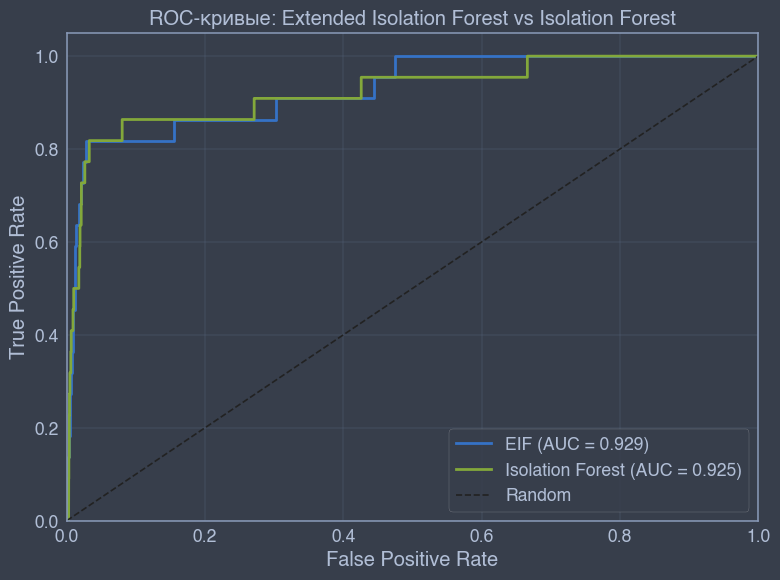

In [36]:
from sklearn.metrics import roc_curve, auc

y_test_scores_eif = eif.score_samples(X_test_scaled)

y_test_scores_if = -iso_forest.decision_function(X_test_scaled)

fpr_eif, tpr_eif, _ = roc_curve(y_test, y_test_scores_eif)
roc_auc_eif = auc(fpr_eif, tpr_eif)

fpr_if, tpr_if, _ = roc_curve(y_test, y_test_scores_if)
roc_auc_if = auc(fpr_if, tpr_if)

plt.figure(figsize=(8, 6))
plt.plot(fpr_eif, tpr_eif, label=f'EIF (AUC = {roc_auc_eif:.3f})', linewidth=2)
plt.plot(fpr_if, tpr_if, label=f'Isolation Forest (AUC = {roc_auc_if:.3f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривые: Extended Isolation Forest vs Isolation Forest')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Возможно, ваш алгоритм выдал большие оценки объектам с негативной разметкой. Постарайтесь выбрать несколько таких объектов и доступно объяснить (= с кодом и графиками), почему так вышло:

354 false positives


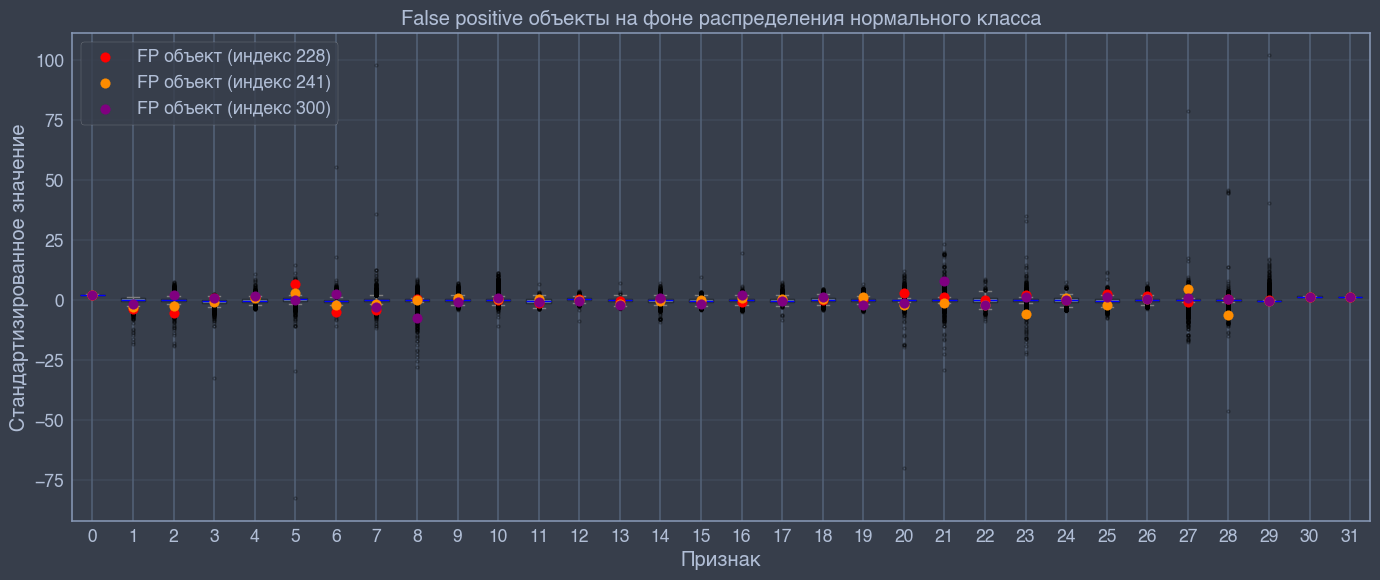

In [37]:
fp_mask = (y_test == 0) & (y_test_pred == 1)
fp_indices = np.where(fp_mask)[0]
print(f"{len(fp_indices)} false positives")

selected_fp = fp_indices[:3]

normal_data = X_test_scaled[y_test == 0]

plt.figure(figsize=(14, 6))
bp = plt.boxplot(normal_data, positions=np.arange(normal_data.shape[1]), 
                 widths=0.6, patch_artist=True,
                 boxprops=dict(facecolor='lightblue', alpha=0.5),
                 medianprops=dict(color='blue'),
                 whiskerprops=dict(color='gray'),
                 capprops=dict(color='gray'),
                 flierprops=dict(marker='o', markersize=2, alpha=0.3, color='gray'))

colors = ['red', 'darkorange', 'purple']
for i, idx in enumerate(selected_fp):
    fp_values = X_test_scaled[idx]
    plt.scatter(np.arange(fp_values.shape[0]), fp_values, 
                color=colors[i], label=f'FP объект (индекс {idx})', s=50, zorder=5)

plt.xlabel('Признак')
plt.ylabel('Стандартизированное значение')
plt.title('False positive объекты на фоне распределения нормального класса')
plt.xticks(np.arange(normal_data.shape[1]))
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

False positive объекты имеют значения признаков, выходящие за пределы основного диапазона нормальных объектов
Особенно заметны отклонения по признакам, где точка выходит далеко за «усы» боксплота. 
Такие необычные сочетания значений приводят к тому, что алгоритм считает их аномалиями, хотя они принадлежат нормальному классу.

**Задание 6. (1 балл).** `sklearn` также предлагает нам и другие методы для поиска аномалий. В этом задании мы предлагаем вам сделать следующее:

Для начала попробуйте использовать методы Local Outlier Factor и One-Class SVM. Сравните результаты с IF и EIF.  

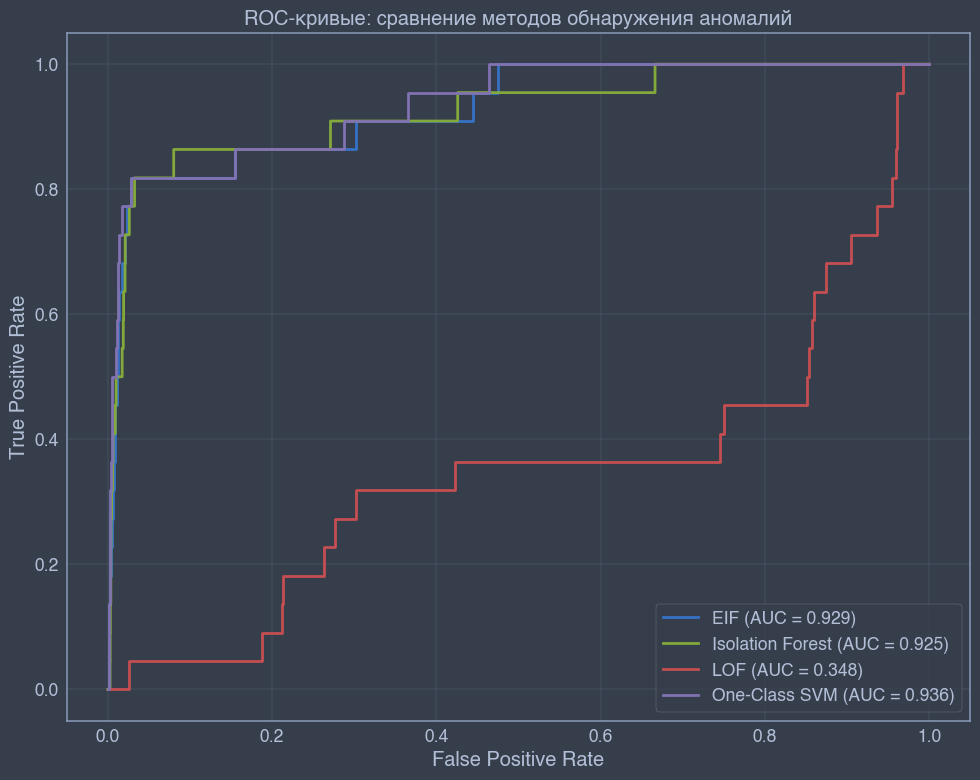

In [38]:
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM

lof = LocalOutlierFactor(n_neighbors=20, contamination='auto', novelty=True)  
lof.fit(X_train_scaled)
y_val_scores_lof = -lof.score_samples(X_val_scaled)
y_test_scores_lof = -lof.score_samples(X_test_scaled)

best_thresh_lof = find_best_threshold(y_val, y_val_scores_lof, thresholds)
y_test_pred_lof = (y_test_scores_lof >= best_thresh_lof).astype(int)
metrics_lof = calc_metrics(y_test, y_test_pred_lof, y_test_scores_lof)

svm = OneClassSVM(nu=CONTAMINATION, kernel='rbf', gamma='scale')
svm.fit(X_train_scaled)
y_val_scores_svm = -svm.decision_function(X_val_scaled)   
y_test_scores_svm = -svm.decision_function(X_test_scaled)

best_thresh_svm = find_best_threshold(y_val, y_val_scores_svm, thresholds)
y_test_pred_svm = (y_test_scores_svm >= best_thresh_svm).astype(int)
metrics_svm = calc_metrics(y_test, y_test_pred_svm, y_test_scores_svm)

plt.figure(figsize=(10, 8))

fpr_eif, tpr_eif, _ = roc_curve(y_test, y_test_scores_eif)
auc_eif = auc(fpr_eif, tpr_eif)
plt.plot(fpr_eif, tpr_eif, label=f'EIF (AUC = {auc_eif:.3f})', linewidth=2)

fpr_if, tpr_if, _ = roc_curve(y_test, y_test_scores_if)
auc_if = auc(fpr_if, tpr_if)
plt.plot(fpr_if, tpr_if, label=f'Isolation Forest (AUC = {auc_if:.3f})', linewidth=2)

fpr_lof, tpr_lof, _ = roc_curve(y_test, y_test_scores_lof)
auc_lof = auc(fpr_lof, tpr_lof)
plt.plot(fpr_lof, tpr_lof, label=f'LOF (AUC = {auc_lof:.3f})', linewidth=2)

fpr_svm, tpr_svm, _ = roc_curve(y_test, y_test_scores_svm)
auc_svm = auc(fpr_svm, tpr_svm)
plt.plot(fpr_svm, tpr_svm, label=f'One-Class SVM (AUC = {auc_svm:.3f})', linewidth=2)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривые: сравнение методов обнаружения аномалий')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

У вас началась депрессия из-за плохих метрик? Не беда! Сейчас давайте сделаем так: все методы, опробованные в этой части, попробуем задействовать для создания дополнительных признаков в данных. Проделайте это (не забудьте, что обучаться здесь нужно на трейне). Теперь возьмите лучшую модель из предыдущей части и обучите на новых данных. Смогли ли unsupervised-методы повысить вам качество?

In [39]:
train_scores_eif = eif.score_samples(X_train_scaled)
val_scores_eif = eif.score_samples(X_val_scaled)
test_scores_eif = eif.score_samples(X_test_scaled)

train_scores_if = -iso_forest.score_samples(X_train_scaled)
val_scores_if = -iso_forest.score_samples(X_val_scaled)
test_scores_if = -iso_forest.score_samples(X_test_scaled)

train_scores_lof = -lof.score_samples(X_train_scaled)
val_scores_lof = -lof.score_samples(X_val_scaled)
test_scores_lof = -lof.score_samples(X_test_scaled)

train_scores_svm = -svm.decision_function(X_train_scaled)
val_scores_svm = -svm.decision_function(X_val_scaled)
test_scores_svm = -svm.decision_function(X_test_scaled)

X_train_extended = np.column_stack([
    X_train_scaled,
    train_scores_eif,
    train_scores_if,
    train_scores_lof,
    train_scores_svm
])
X_val_extended = np.column_stack([
    X_val_scaled,
    val_scores_eif,
    val_scores_if,
    val_scores_lof,
    val_scores_svm
])
X_test_extended = np.column_stack([
    X_test_scaled,
    test_scores_eif,
    test_scores_if,
    test_scores_lof,
    test_scores_svm
])


model_ext = CatBoostClassifier(iterations=CATBOOST_ITERATIONS,
                               random_state=RANDOM_STATE,
                               verbose=0)
model_ext.fit(X_train_extended, y_train)

y_val_proba_ext = model_ext.predict_proba(X_val_extended)[:, 1]
thresholds = np.linspace(0.01, 0.99, 100)
best_thresh_ext = find_best_threshold(y_val, y_val_proba_ext, thresholds)

y_test_proba_ext = model_ext.predict_proba(X_test_extended)[:, 1]
y_test_pred_ext = (y_test_proba_ext >= best_thresh_ext).astype(int)
metrics_ext = calc_metrics(y_test, y_test_pred_ext, y_test_proba_ext)

model_base = CatBoostClassifier(iterations=CATBOOST_ITERATIONS,
                               random_state=RANDOM_STATE,
                               verbose=0)
model_base.fit(X_train_scaled, y_train)

y_val_proba_base = model_base.predict_proba(X_val_scaled)[:, 1]
best_thresh_base = find_best_threshold(y_val, y_val_proba_base, thresholds)

y_test_proba_base = model_base.predict_proba(X_test_scaled)[:, 1]
y_test_pred_base = (y_test_proba_base >= best_thresh_base).astype(int)
metrics_base = calc_metrics(y_test, y_test_pred_base, y_test_proba_base)

for k, v in metrics_base.items():
    print(f"  {k}: {v:.4f}")

print("\nМодель с дополнительными признаками (EIF, IF, LOF, SVM):")
for k, v in metrics_ext.items():
    print(f"  {k}: {v:.4f}")

  Accuracy: 0.9996
  Precision: 0.7273
  Recall: 0.7273
  F1: 0.7273
  MCC: 0.7271
  Kappa: 0.7271
  PR-AUC: 0.6998

Модель с дополнительными признаками (EIF, IF, LOF, SVM):
  Accuracy: 0.9995
  Precision: 0.6957
  Recall: 0.7273
  F1: 0.7111
  MCC: 0.7111
  Kappa: 0.7109
  PR-AUC: 0.6869


**Бонус. (0.1 балла).**

При сдаче проверяющий запустит следующую клетку один раз. Если она даст положительный результат, вы получите 0.1 бонусных балла. Если она даст отрицательный результат, вы получите -0.1 бонусных балла. 

Если вы хотите отказаться от сдачи данного задания, допишите "хочу" после двоеточия: `хочу`

Ниже вы можете попрактиковаться и оценить ваши силы (изменять код ячейки запрещается!)

In [40]:
import random

rng = random.SystemRandom(0)
rng.uniform(-1.0, 1.0)

-0.3036628142062492